# Importation des bibliothèques

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM, Embedding

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Importation du dataset

In [6]:
imdb= pd.read_csv("IMDB Dataset.csv")

In [8]:
imdb.info()
imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


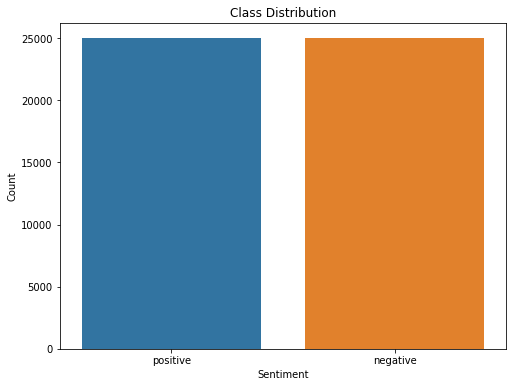

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=imdb)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [21]:
imdb.iloc[3]

review       Basically there's a family where a little boy ...
sentiment                                             negative
Name: 3, dtype: object

# pretraitement

## nettoyer les données textuelles

In [22]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [24]:
X = []
sentences = list(imdb['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [25]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

## convertir les étiquettes en chiffres

In [26]:
y = imdb['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

## Diviser le dataset en training et test sets.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)

# La couche de l’embedding

## dictionnaire word-to-index

In [50]:
tokenizer = Tokenizer(num_words=5000) #top 5000 most frequent words
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [51]:
X_train[3]

[8,
 1547,
 247,
 2628,
 5,
 443,
 4385,
 1871,
 14,
 30,
 31,
 1062,
 390,
 4,
 968,
 119,
 22,
 118,
 4197,
 29,
 44,
 3,
 1,
 17,
 78,
 118,
 4125,
 122,
 502,
 18,
 2,
 31,
 37,
 555,
 4,
 25,
 2839,
 1,
 2628,
 221,
 77,
 4,
 170,
 1663,
 777,
 57,
 59,
 924,
 7,
 44,
 1974,
 950,
 1164,
 3355,
 57,
 376,
 754,
 264,
 30,
 1318,
 1746,
 1326,
 31,
 376,
 529,
 1135,
 491,
 19,
 4,
 736,
 745,
 701,
 39,
 3,
 1,
 1320,
 3,
 251,
 7,
 8,
 407,
 1,
 103,
 2654,
 1749,
 3813,
 1420,
 3515,
 7,
 1,
 125,
 46,
 130,
 147,
 749,
 9,
 8,
 16,
 266,
 52,
 1975,
 3,
 1,
 3,
 3626,
 13,
 1,
 57,
 6,
 3735,
 7,
 430,
 752,
 2,
 9,
 6,
 5,
 1428,
 4,
 1563,
 2543,
 51,
 1,
 2037,
 15,
 610,
 94,
 1064,
 276,
 3,
 2,
 36,
 1415,
 14,
 57,
 2990,
 2628,
 63,
 29,
 87,
 428,
 332,
 3432]

La taille de chaque liste est différente car les phrases possèdent des tailles différentes.
Le script ci-dessous trouve la taille du vocabulaire, puis effectue un remplissage sur
l'ensemble d'entraînement et de test.

In [52]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [53]:
vocab_size

92547

Les listes ont la même longueur, c'est-à-dire 100. De plus, la variable vocabulary_size contient maintenant une valeur 92547, ce qui signifie que le corpus contient 92547 mots uniques.

##  GloVe : Global Vectors for Word Representation

créons un dictionnaire qui contiendra des mots en tant que clés et
leur liste d’embeddings correspondante en tant que valeurs.

In [54]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf8")
for i in range(5):
    line = glove_file.readline()
    print(line)
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:],dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

Enfin, nous allons créer une matrice d’embeddings où chaque numéro de ligne
correspondra à l'index du mot dans le corpus. La matrice aura 100 colonnes où chaque
colonne contiendra les embeddings GloVe pour les mots de notre corpus.

In [55]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [58]:
embedding_matrix[7]

array([ 0.085703  , -0.22201   ,  0.16569   ,  0.13372999,  0.38238999,
        0.35400999,  0.01287   ,  0.22461   , -0.43816999,  0.50164002,
       -0.35874   , -0.34983   ,  0.055156  ,  0.69647998, -0.17958   ,
        0.067926  ,  0.39100999,  0.16039   , -0.26635   , -0.21138   ,
        0.53697997,  0.49379   ,  0.93660003,  0.66902   ,  0.21793   ,
       -0.46641999,  0.22383   , -0.36204001, -0.17656   ,  0.17479999,
       -0.20367   ,  0.13931   ,  0.019832  , -0.10413   , -0.20243999,
        0.55002999, -0.15459999,  0.98654997, -0.26863   , -0.29089999,
       -0.32866001, -0.34187999, -0.16943   , -0.42001   , -0.046727  ,
       -0.16327   ,  0.70823997, -0.74910998, -0.091559  , -0.96178001,
       -0.19746999,  0.10282   ,  0.55220997,  1.38160002, -0.65635997,
       -3.25020003, -0.31556001, -1.20550001,  1.77090001,  0.40259999,
       -0.79826999,  1.15970004, -0.33041999,  0.31382   ,  0.77385998,
        0.22595   ,  0.52471   , -0.034053  ,  0.32047999,  0.07

# modelisation

## A. Classification avec un simple réseau de neurones

In [63]:
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense

# Création du modèle séquentiel
ann_model = Sequential()

# Ajout de la couche d'embedding
ann_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Ajout de la couche Flatten
ann_model.add(Flatten())

# Ajout de la couche Dense
ann_model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history=ann_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 3s 9ms/step - loss: 0.5926 - acc: 0.6811 - val_loss: 0.5274 - val_acc: 0.7389
Epoch 2/6
250/250 [==============================] - 2s 8ms/step - loss: 0.4851 - acc: 0.7686 - val_loss: 0.5193 - val_acc: 0.7464
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4531 - acc: 0.7903 - val_loss: 0.5235 - val_acc: 0.7456
Epoch 4/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4326 - acc: 0.8003 - val_loss: 0.5352 - val_acc: 0.7366
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4131 - acc: 0.8127 - val_loss: 0.5277 - val_acc: 0.7505
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.4024 - acc: 0.8194 - val_loss: 0.5384 - val_acc: 0.7467


In [64]:
score = ann_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.5432 - acc: 0.7412
Test Score: 0.5431818962097168
Test Accuracy: 0.7411999702453613


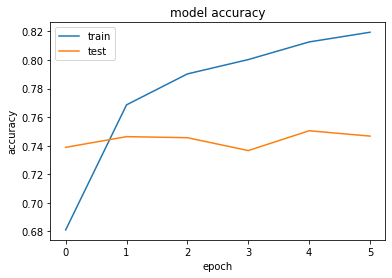

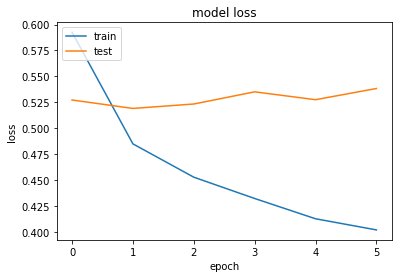

In [65]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## B. Classification avec un réseau de neurones convolutionnel

In [66]:
from keras.layers import  Conv1D, MaxPooling1D

# Création du modèle séquentiel
cnn_model = Sequential()

# Ajout de la couche d'embedding
cnn_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

# Ajout de la couche Convolutional 1D
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Ajout de la couche de pooling max 1D
cnn_model.add(MaxPooling1D())

# Aplatir les sorties de la couche de pooling
cnn_model.add(Flatten())

# Ajout de la couche Dense
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history=cnn_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 73s 289ms/step - loss: 0.5203 - acc: 0.7231 - val_loss: 0.3848 - val_acc: 0.8274
Epoch 2/6
250/250 [==============================] - 57s 227ms/step - loss: 0.3173 - acc: 0.8634 - val_loss: 0.3354 - val_acc: 0.8522
Epoch 3/6
250/250 [==============================] - 65s 262ms/step - loss: 0.2423 - acc: 0.9038 - val_loss: 0.3285 - val_acc: 0.8594
Epoch 4/6
250/250 [==============================] - 78s 314ms/step - loss: 0.1792 - acc: 0.9344 - val_loss: 0.3491 - val_acc: 0.8572
Epoch 5/6
250/250 [==============================] - 72s 288ms/step - loss: 0.1109 - acc: 0.9667 - val_loss: 0.3881 - val_acc: 0.8510
Epoch 6/6
250/250 [==============================] - 82s 330ms/step - loss: 0.0580 - acc: 0.9894 - val_loss: 0.4441 - val_acc: 0.8444


In [67]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 6s 18ms/step - loss: 0.4165 - acc: 0.8470
Test Score: 0.41654273867607117
Test Accuracy: 0.847000002861023


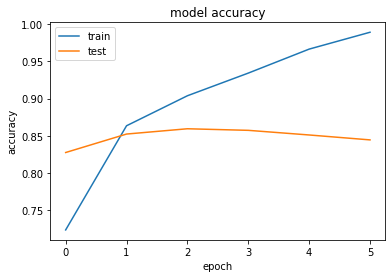

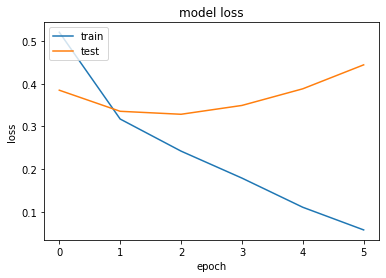

In [68]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## C. Classification avec un réseau de neurones récurrent (LSTM)

In [69]:
lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

lstm_model.add(LSTM(units=128))

lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history=lstm_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 189s 721ms/step - loss: 0.5024 - acc: 0.7492 - val_loss: 0.3730 - val_acc: 0.8372
Epoch 2/6
250/250 [==============================] - 207s 830ms/step - loss: 0.3402 - acc: 0.8537 - val_loss: 0.3622 - val_acc: 0.8624
Epoch 3/6
250/250 [==============================] - 184s 738ms/step - loss: 0.2899 - acc: 0.8811 - val_loss: 0.3171 - val_acc: 0.8662
Epoch 4/6
250/250 [==============================] - 178s 713ms/step - loss: 0.2541 - acc: 0.8980 - val_loss: 0.3375 - val_acc: 0.8537
Epoch 5/6
250/250 [==============================] - 162s 647ms/step - loss: 0.2317 - acc: 0.9097 - val_loss: 0.3246 - val_acc: 0.8656
Epoch 6/6
250/250 [==============================] - 157s 626ms/step - loss: 0.2048 - acc: 0.9218 - val_loss: 0.3424 - val_acc: 0.8609


In [70]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 22s 70ms/step - loss: 0.3240 - acc: 0.8660
Test Score: 0.3239685297012329
Test Accuracy: 0.8659999966621399


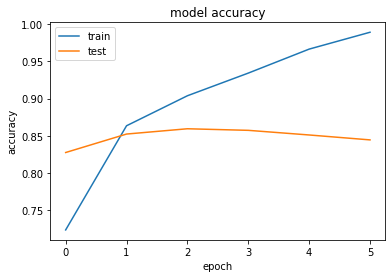

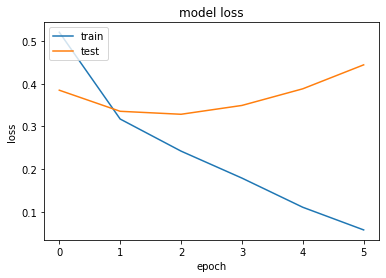

In [71]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

l'accuracy du 1er classifieur (un simple réseau de neurones): 
l'accuracy du 2eme classifieur (CNN): 
l'accuracy du 3eme classifieur (LSTM): 


In [81]:
single_input_data = X_test[4] 
input_data = np.array([single_input_data])
predicted_prob = lstm_model.predict(input_data)

predicted_class = int(np.round(predicted_prob))

print("Predicted Probability:", predicted_prob)
print("Predicted Class:", predicted_class)
print("correct Class:", y_test[4])

1/1 [==============================] - 0s 140ms/step
Predicted Probability: [[0.00715933]]
Predicted Class: 0
correct Class: 0


# comparaison embedding / classifieur

## utils

In [ ]:
def plot_results(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()


def evaluate_model(model):
  score = model.evaluate(X_test, y_test, verbose=0)
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])

In [ ]:
## models

In [91]:
from keras.layers import  GRU

from keras.callbacks import EarlyStopping

def train_lstm(out_dim):
    lstm_model = Sequential()

    lstm_model.add(Embedding(vocab_size, out_dim, weights=[embedding_matrix], input_length=maxlen))

    lstm_model.add(LSTM(units=128))

    lstm_model.add(Dense(units=1, activation='sigmoid'))

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = lstm_model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])
    
    return lstm_model, history

def train_cnn_rnn(out_dim):
    model = Sequential()

    model.add(Embedding(vocab_size, out_dim, weights=[embedding_matrix], input_length=maxlen))

    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    model.add(MaxPooling1D())
    model.add(LSTM(units=128)) 


    model.add(Flatten())

    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])
    
    return model, history

def train_gru(out_dim):
    model = Sequential()

    model.add(Embedding(vocab_size, out_dim, weights=[embedding_matrix], input_length=maxlen))

    model.add(GRU(units=128)) 

    model.add(Flatten())

    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])
    
    return model , history


In [92]:
def experience(out_dim, train ):
    model, history= train(out_dim)
    plot_results(history)
    evaluate_model(model)
    

In [93]:
experience(100, train_cnn_rnn)

Epoch 1/6
250/250 [==============================] - 116s 452ms/step - loss: 0.4891 - acc: 0.7582 - val_loss: 0.4055 - val_acc: 0.8209
Epoch 2/6
250/250 [==============================] - 119s 475ms/step - loss: 0.3165 - acc: 0.8658 - val_loss: 0.3158 - val_acc: 0.8621
Epoch 3/6
228/250 [==========================>...] - ETA: 9s - loss: 0.2624 - acc: 0.8950 

KeyboardInterrupt: 